Optimal Energy Group Indices: [239 150 269 273 174 157  10 283 164 142   7 149  38  69  29 117  58 291
   6 182 129 168  93  19  75 243 136  59  40 285 226 251 291 267 230 208
  67 133 286 122   4  13 109  91  12 246 175 114  27  41 140 263 154 221
 215  42 218  79 202   7 126  53 186 232  68  20 233  31 135 227  90 183
  18  71  48 220 207  98 128 209 146 107  66 264 124 151  99 213 244 179
 250 198 141  36  15 124  95 104  49 159  37 119 193 143 137 172  81 262
 111  32 200 184 152  60  80 147  83 148 127   5 293 224  88 237  35 178
 106 247 226 176 171 115 260  27 256 191 231  86  52  56  65  62 131  39
 297 259 216 295 201 206]
Optimal Signal Group Indices: [0, 1, 2, 3, 8, 9, 11, 14, 16, 17, 21, 22, 23, 24, 25, 26, 28, 30, 33, 34, 43, 44, 45, 46, 47, 50, 51, 54, 55, 57, 61, 63, 64, 70, 72, 73, 74, 76, 77, 78, 82, 84, 85, 87, 89, 92, 94, 96, 97, 100, 101, 102, 103, 105, 108, 110, 112, 113, 116, 118, 120, 121, 123, 125, 130, 132, 134, 138, 139, 144, 145, 153, 155, 156, 158, 160, 161,

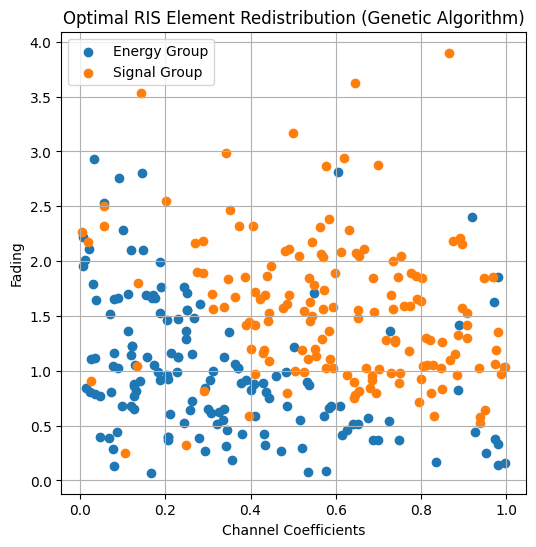

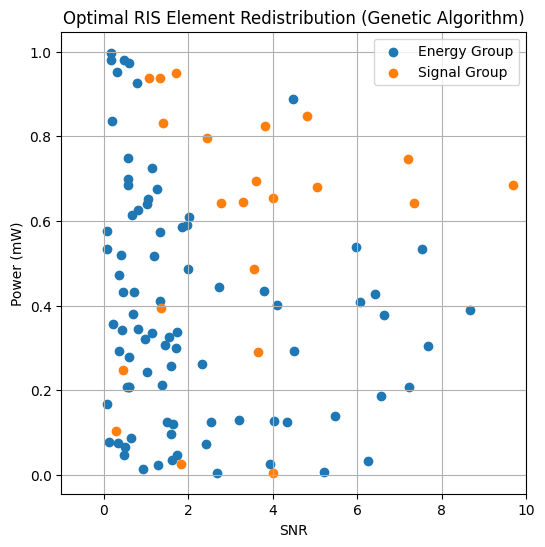

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01
path_loss_exponent = 2

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)

# Generate channel coefficients and Rayleigh fading
channel_coefficients = np.random.rand(num_elements)
rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)

def calculate_elements(channel_coefficients, fading):
    snr_values = channel_coefficients * fading / (channel_coefficients * (1 - fading) + noise_power)
    power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
    return np.column_stack((snr_values, power_values))

elements = calculate_elements(channel_coefficients, rayleigh_fading)

def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_power + signal_power
    return snr, power

def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    return energy_indices, signal_indices

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(channel_coefficients[energy_indices], rayleigh_fading[energy_indices])
    return 1 / (snr * power)

def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, rayleigh_fading)

    # Initialize population
    population = [energy_indices] * population_size

    for _ in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(channel_coefficients[best_energy_indices], rayleigh_fading[best_energy_indices])
        
    return best_energy_indices, best_signal_indices, best_snr, best_power

# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance ** path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance ** path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100

# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("Optimal Power:", best_power, "mW")
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS:", best_snr, "dB")
print("Improvement Percentage:", improvement_percentage, "%")

# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(channel_coefficients[best_energy_indices], rayleigh_fading[best_energy_indices], label='Energy Group')
plt.scatter(channel_coefficients[best_signal_indices], rayleigh_fading[best_signal_indices], label='Signal Group')
plt.xlabel('Channel Coefficients')
plt.ylabel('Fading')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution based on SNR and Power
plt.figure(figsize=(6, 6))
plt.scatter(elements[best_energy_indices, 0], elements[best_energy_indices, 1], label='Energy Group')
plt.scatter(elements[best_signal_indices, 0], elements[best_signal_indices, 1], label='Signal Group')
plt.xlabel('SNR')
plt.xlim(-1, 10)
plt.ylabel('Power (mW)')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()


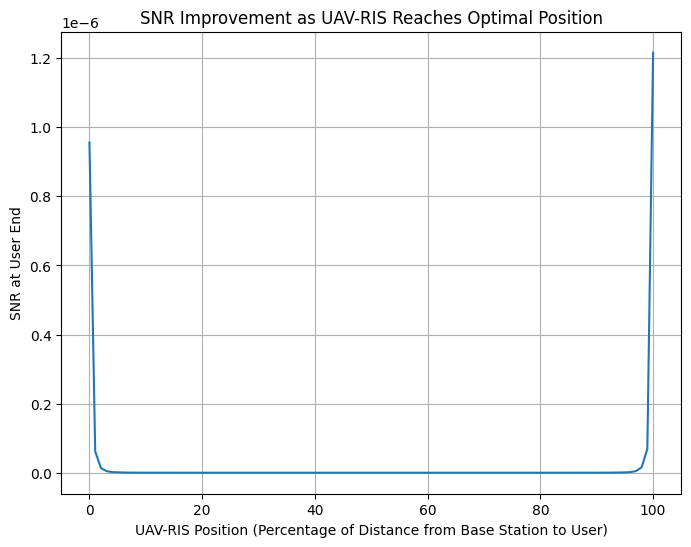

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = np.array([100, 100])
base_station_position = np.array([0, 0])

# Genetic Algorithm parameters
population_size = 10
num_generations = 10
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01
path_loss_exponent = 4

def calculate_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

def path_loss(distance):
    return 1 / (distance ** path_loss_exponent + 1e-9)

def rayleigh_fading():
    return np.random.exponential()

def calculate_channel_coefficients(uav_position):
    user_uav_distance = calculate_distance(user_position, uav_position)
    bs_uav_distance = calculate_distance(base_station_position, uav_position)
    channel_gain = path_loss(user_uav_distance) * path_loss(bs_uav_distance)
    return channel_gain * np.random.exponential(scale=1.0, size=num_elements)


def calculate_elements(channel_coefficients, fading):
    snr_values = channel_coefficients * fading / (channel_coefficients * (1 - fading) + noise_power)
    power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
    return np.column_stack((snr_values, power_values))

def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_power + signal_power
    return snr, power

def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    return energy_indices, signal_indices

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(channel_coefficients[energy_indices], fading[energy_indices])
    return 1 / (snr * power)

def genetic_algorithm(uav_position):
    # Generate channel coefficients
    global channel_coefficients
    channel_coefficients = calculate_channel_coefficients(uav_position)
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)
    # Initialize population
    population = [energy_indices] * population_size

    for _ in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(channel_coefficients[best_energy_indices], rayleigh_fading[best_energy_indices])
    

    return best_energy_indices, best_signal_indices, best_snr, best_power


# Generate fading
fading = np.random.rand(num_elements)

# Simulate UAV-RIS movement and optimization
uav_positions = [base_station_position + x * (user_position - base_station_position) / 100 for x in range(1, 100)]
snr_values = []

for uav_position in uav_positions:
    channel_coefficients = calculate_channel_coefficients(uav_position)
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)
    best_snr, best_power = calculate_snr_power(channel_coefficients[energy_indices], fading[energy_indices])
    snr_values.append(best_snr)

# Plot SNR improvement
plt.figure(figsize=(8, 6))
plt.plot(np.linspace(0, 100, 99), snr_values)
plt.xlabel('UAV-RIS Position (Percentage of Distance from Base Station to User)')
plt.ylabel('SNR at User End')
plt.title('SNR Improvement as UAV-RIS Reaches Optimal Position')
plt.grid(True)
plt.show()


Generation 1: Best Fitness: 0.24221916283482242
Generation 2: Best Fitness: 0.24054665255329916
Generation 3: Best Fitness: 0.23766605078771033
Generation 4: Best Fitness: 0.23766605078771033
Generation 5: Best Fitness: 0.23002676599603472
Generation 6: Best Fitness: 0.23766605078771033
Generation 7: Best Fitness: 0.23766605078771033
Generation 8: Best Fitness: 0.23027982731183477
Generation 9: Best Fitness: 0.23027982731183477
Generation 10: Best Fitness: 0.23027982731183477
Generation 11: Best Fitness: 0.22320624509362033
Generation 12: Best Fitness: 0.2163162273845935
Generation 13: Best Fitness: 0.2163162273845935
Generation 14: Best Fitness: 0.21941441691306013
Generation 15: Best Fitness: 0.21941441691306013
Generation 16: Best Fitness: 0.2163162273845935
Generation 17: Best Fitness: 0.2075047216328649
Generation 18: Best Fitness: 0.22028817447592
Generation 19: Best Fitness: 0.2142786818597426
Generation 20: Best Fitness: 0.21245965700187958
Generation 21: Best Fitness: 0.215554

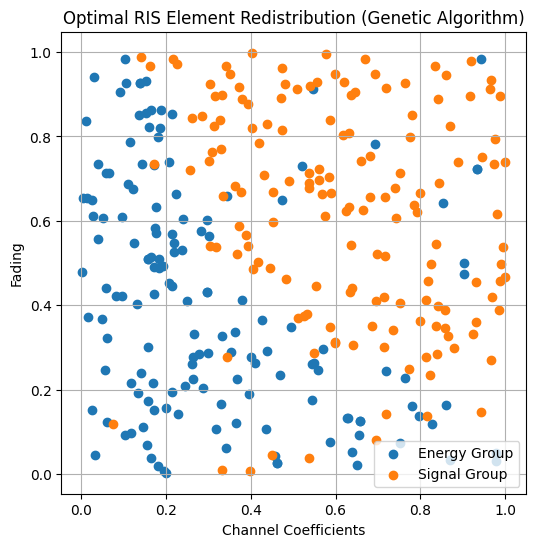

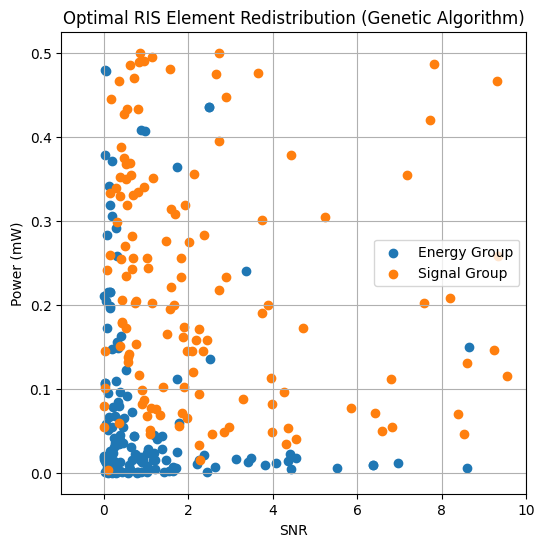

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 300

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Parameters
energy_conversion_efficiency = 0.5  # Example value for energy conversion efficiency
P_transmitted = 1  # Example value for transmitted power
path_loss_exponent = 2  # Path loss exponent

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)

# Generate channel coefficients and fading
channel_coefficients = np.random.rand(num_elements)
fading = np.random.rand(num_elements)

def calculate_elements(channel_coefficients, fading):
    snr_values = channel_coefficients * fading / (channel_coefficients * (1 - fading) + noise_power)
    power_values = energy_conversion_efficiency * (channel_coefficients ** 2) * P_transmitted  # Power harvested
    return np.column_stack((snr_values, power_values))

elements = calculate_elements(channel_coefficients, fading)

def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_conversion_efficiency * np.sum(channel_coefficients ** 2) * P_transmitted  # Total harvested power
    return snr, power


def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading) 
    energy_indices = sorted_indices[:num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2:]
    return energy_indices, signal_indices

def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(channel_coefficients[energy_indices], fading[energy_indices])
    return 1 / (snr * power)

def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)

    # Initialize population
    population = [energy_indices] * population_size

    for generation in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
                child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
            else:
                child1 = parent1
                child2 = parent2
            
            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])
        
        population = new_population
        
        best_individual = min(population, key=lambda ind: evaluate_fitness(ind, list(set(range(num_elements)) - set(ind))))
        best_fitness = evaluate_fitness(best_individual, list(set(range(num_elements)) - set(best_individual)))

        # print(f"Generation {generation + 1}: Best Individual: {best_individual}")
        print(f"Generation {generation + 1}: Best Fitness: {best_fitness}")

        
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, best_power = calculate_snr_power(channel_coefficients[best_energy_indices], fading[best_energy_indices])
        
    return best_energy_indices, best_signal_indices, best_snr, best_power

# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance ** path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance ** path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100



# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS (Optimized):", best_snr, "dB")
print("Optimal Power (Optimized):", best_power, "mW")
print("Improvement Percentage:", improvement_percentage, "%")


# Visualize
plt.figure(figsize=(6, 6))
plt.scatter(channel_coefficients[best_energy_indices], fading[best_energy_indices], label='Energy Group')
plt.scatter(channel_coefficients[best_signal_indices], fading[best_signal_indices], label='Signal Group')
plt.xlabel('Channel Coefficients')
plt.ylabel('Fading')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the distribution based on SNR and Power
plt.figure(figsize=(6, 6))
plt.scatter(elements[best_energy_indices, 0], elements[best_energy_indices, 1], label='Energy Group')
plt.scatter(elements[best_signal_indices, 0], elements[best_signal_indices, 1], label='Signal Group')
plt.xlabel('SNR')
#x from 0 to 10
plt.xlim(-1, 10)
plt.ylabel('Power (mW)')
plt.title('Optimal RIS Element Redistribution (Genetic Algorithm)')
plt.legend()
plt.grid(True)
plt.show()

